# Filtering with stochastic volatility model using importance sampling

This demo applies variational message passing with messages approximated using importance sampling to a filtering problem with a stochastic volatility model.

We choose hierarchical Gaussian filter with $\kappa=1$ and $\omega=0$.

In [1]:
using ForneyLab
using Distributions: Normal

## Data generation

In [2]:
#Generate data
T = 200

vz, vy = 0.1, 1

z_data_0 = 0
z_data = [rand(Normal(z_data_0,sqrt(vz)))]
x_data_0 = 0
x_data = [rand(Normal(x_data_0,sqrt(exp(z_data[1]))))]
y_data = [rand(Normal(x_data[1],sqrt(vy)))]
for t=2:T
    append!(z_data, rand(Normal(z_data[end],sqrt(vz))))
    append!(x_data, rand(Normal(x_data[end],sqrt(exp(z_data[end])))))
    append!(y_data, rand(Normal(x_data[end],sqrt(vy))))
end

## Model specification

In [3]:
g = FactorGraph()


@RV m_z_t_min 
@RV v_z_t_min 
@RV z_t_min ~ GaussianMeanVariance(m_z_t_min, v_z_t_min)
model_vz = 0.1
@RV z_t ~ GaussianMeanVariance(z_t_min, model_vz)

@RV m_x_t_min
@RV v_x_t_min
@RV x_t_min ~ GaussianMeanVariance(m_x_t_min, v_x_t_min)

f(z) = 1/exp(z)
@RV wx_t ~ Nonlinear{ImportanceSampling}(z_t,g=f)
@RV x_t ~ GaussianMeanPrecision(x_t_min, wx_t)
model_vy = 0.1
@RV y_t ~ GaussianMeanVariance(x_t, model_vy)

# Placeholders for prior
placeholder(m_z_t_min, :m_z_t_min)
placeholder(v_z_t_min, :v_z_t_min)

# Placeholders for prior
placeholder(m_x_t_min, :m_x_t_min)
placeholder(v_x_t_min, :v_x_t_min)

# Placeholder for data
placeholder(y_t, :y_t);

In [4]:
ForneyLab.draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 5413927651628961065 -->
 
 5413927651628961065 
 
 placeholder_m_x_t_min 
 
<!-- 11569356770587965116 -->
 
 11569356770587965116 
 
 𝒩 
 gaussianmeanvariance_3 
 
<!-- 5413927651628961065--11569356770587965116 -->
 
 5413927651628961065--11569356770587965116 
 
 m_x_t_min 
 2 m 
 1 out 
 
<!-- 11064149452230100989 -->
 
 11064149452230100989 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 13216179510973004332 -->
 
 13216179510973004332 
 
 Nonlinear{ImportanceSampling} 
 nonlinear_1 
 
<!-- 11064149452230100989--13216179510973004332 -->
 
 11064149452230100989--13216179510973004332 
 
 wx_t 
 1 out 
 3 w 
 
<!-- 11064149452230100989--11569356770587965116 -->
 
 11064149452230100989--11569356770587965116 
 
 x_t_min 
 1 out 
 2 m 
 
<!-- 4811951553134195913 -->
 
 4811951553134195913 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 8345929271649328898 -->
 
 8345929271649328898 
 
 𝒩 
 gaussianmeanvariance_2 
 
<!-- 8345929271649328898--4811951553134195913 -->
 
 8345929271649328898--4811951553134195913 
 
 z_t_min 
 1 out 
 2 m 
 
<!-- 8500714805373245264 -->
 
 8500714805373245264 
 
 clamp_1 
 
<!-- 8345929271649328898--8500714805373245264 -->
 
 8345929271649328898--8500714805373245264 
 
 clamp_1 
 1 out 
 3 v 
 
<!-- 7012966825900345529 -->
 
 7012966825900345529 
 
 placeholder_v_z_t_min 
 
<!-- 7012966825900345529--4811951553134195913 -->
 
 7012966825900345529--4811951553134195913 
 
 v_z_t_min 
 3 v 
 1 out 
 
<!-- 2191757951087766723 -->
 
 2191757951087766723 
 
 clamp_2 
 
<!-- 1318296868348288091 -->
 
 1318296868348288091 
 
 𝒩 
 gaussianmeanvariance_4 
 
<!-- 1318296868348288091--11064149452230100989 -->
 
 1318296868348288091--11064149452230100989 
 
 x_t 
 1 out 
 2 m 
 
<!-- 1318296868348288091--2191757951087766723 -->
 
 1318296868348288091--2191757951087766723 
 
 clamp_2 
 1 out 
 3 v 
 
<!-- 13216179510973004332--8345929271649328898 -->
 
 13216179510973004332--8345929271649328898 
 
 z_t 
 1 out 
 2 in1 
 
<!-- 3211931135221404229 -->
 
 3211931135221404229 
 
 placeholder_v_x_t_min 
 
<!-- 3211931135221404229--11569356770587965116 -->
 
 3211931135221404229--11569356770587965116 
 
 v_x_t_min 
 3 v 
 1 out 
 
<!-- 12771739329306887153 -->
 
 12771739329306887153 
 
 placeholder_y_t 
 
<!-- 12771739329306887153--1318296868348288091 -->
 
 12771739329306887153--1318296868348288091 
 
 y_t 
 1 out 
 1 out 
 
<!-- 7888524917837816237 -->
 
 7888524917837816237 
 
 placeholder_m_z_t_min 
 
<!-- 7888524917837816237--4811951553134195913 -->
 
 7888524917837816237--4811951553134195913 
 
 m_z_t_min 
 2 m 
 1 out

## Inference specification

In [5]:
PosteriorFactorization()

q_x = PosteriorFactor([x_t, x_t_min], id=:XMF)
q_z = PosteriorFactor(z_t, id=:ZMF)
q_z_t_min = PosteriorFactor(z_t_min, id=:ZMinMF)
algo_mf = variationalAlgorithm();

# Algorithm generation

In [6]:
source_code = algorithmSourceCode(algo_mf)
eval(Meta.parse(source_code));

## Execution

In [7]:
# Define values for prior statistics
m_z_0, v_z_0 = 0.0, 10.0
m_x_0, v_x_0 = 0.0, 10.0

m_z = Vector{Float64}(undef, T)
v_z = Vector{Float64}(undef, T)
m_x = Vector{Float64}(undef, T)
v_x = Vector{Float64}(undef, T)

m_z_t_min, v_z_t_min = m_z_0, v_z_0
m_x_t_min, v_x_t_min = m_x_0, v_x_0
mwx_t_min, vwx_t_min = f(m_z_0), v_z_0

n_its = 10
marginals_mf = Dict()
for t = 1:T
    # Prepare data and prior statistics
    data = Dict(:y_t       => y_data[t],
                :m_z_t_min => m_z_t_min,
                :v_z_t_min => v_z_t_min,
                :m_x_t_min => m_x_t_min,
                :v_x_t_min => v_x_t_min)
    
    # Initial recognition distributions
    marginals_mf[:z_t] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_z_t_min, v=v_z_t_min)
    marginals_mf[:x_t_min] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_x_t_min, v=v_x_t_min)
    marginals_mf[:z_t_min] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=m_z_t_min, v=v_z_t_min)
    marginals_mf[:wx_t] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=mwx_t_min, v=vwx_t_min)
    
    # Execute algorithm
    for i = 1:n_its
        stepZMinMF!(data, marginals_mf)
        stepXMF!(data, marginals_mf)
        stepZMF!(data, marginals_mf)
    end

    m_z_t_min = mean(marginals_mf[:z_t])
    v_z_t_min = var(marginals_mf[:z_t])
    m_x_t_min = mean(marginals_mf[:x_t])
    v_x_t_min = var(marginals_mf[:x_t])
    mwx_t_min = mean(marginals_mf[:wx_t])
    vwx_t_min = var(marginals_mf[:wx_t])
    
    # Store to buffer 
    m_x[t] = m_x_t_min
    v_x[t] = v_x_t_min
    m_z[t] = m_z_t_min
    v_z[t] = v_z_t_min
end

## Results

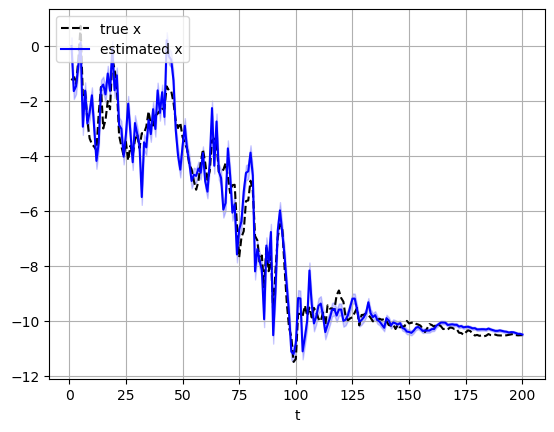

In [8]:
using PyPlot

plot(collect(1:T), x_data, "k--", label="true x")
plot(collect(1:T), m_x, "b-", label="estimated x")
fill_between(1:T, m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.2);
grid("on")
xlabel("t")
legend(loc="upper left");